In [1]:
import geopandas as gpd
import pandas as pd

import mapillary as mly

import glob

from datetime import datetime



### osm-netzwerk einlesen

In [2]:
#set_date = "251010" 
#set_date = "251022" 
set_date = "251115" 


cycleways=gpd.read_parquet(f"processed_osm_files/processed_cycleways_germany_{set_date}.parquet")
motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")

print("number of cycleways:", len(cycleways))
print("number of motorways:", len(motorways))

number of cycleways: 5468811
number of motorways: 69824


In [3]:
cycleways.head()

,osm_id,highway,bicycle,bicycle_forward,bicycle_backward,cycleway,cycleway_left,cycleway_right,cycleway_both,cycleway_lane,...,maxspeed,maxspeed_conditional,maxspeed_backward,maxspeed_forward,maxspeed_type,name,ref,surface,width,geometry
0,99,tertiary,None,None,None,None,None,no,None,None,...,None,None,None,None,None,None,None,asphalt,None,"LINESTRING (11.36639 48.17411, 11.36643 48.174..."
1,104,unclassified,None,None,None,None,None,None,no,None,...,50,None,None,None,None,Münzmeisterstraße,None,asphalt,None,"LINESTRING (13.74142 51.02366, 13.74139 51.023..."
2,105,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Altpestitz,None,sett,None,"LINESTRING (13.73698 51.01663, 13.73643 51.016..."
3,107,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Trienter Straße,None,asphalt,None,"LINESTRING (13.73507 51.01914, 13.73505 51.019..."
4,110,residential,None,None,None,None,None,None,no,None,...,50,None,None,None,sign,Heinrich-Greif-Straße,None,concrete:plates,None,"LINESTRING (13.74296 51.02871, 13.74295 51.028..."


In [4]:
cycleways.columns

Index(['osm_id', 'highway', 'bicycle', 'bicycle_forward', 'bicycle_backward',
       'cycleway', 'cycleway_left', 'cycleway_right', 'cycleway_both',
       'cycleway_lane', 'cycleway_track', 'cycleway_opposite',
       'cycleway_shared_lane', 'sidewalk_right_bicycle',
       'sidewalk_left_bicycle', 'sidewalk_both_bicycle', 'maxspeed',
       'maxspeed_conditional', 'maxspeed_backward', 'maxspeed_forward',
       'maxspeed_type', 'name', 'ref', 'surface', 'width', 'geometry'],
      dtype='object')

In [5]:
filtered_cycleways = cycleways[
    (cycleways["bicycle"].isin(["designated"])) |
    (cycleways["bicycle_backward"].isin(["designated"])) |
    (cycleways["bicycle_forward"].isin(["designated"])) |
    (cycleways["highway"].isin(["cycleway"])) |
    (cycleways["cycleway"].notnull() & (cycleways["cycleway"] != "no")) |
    (cycleways["cycleway_left"].notnull() & (cycleways["cycleway_left"] != "no")) |
    (cycleways["cycleway_right"].notnull() & (cycleways["cycleway_right"] != "no")) |
    (cycleways["cycleway_both"].notnull() & (cycleways["cycleway_both"] != "no")) |
    (cycleways["cycleway_lane"].notnull() & (cycleways["cycleway_lane"] != "no")) |
    (cycleways["cycleway_track"].notnull() & (cycleways["cycleway_track"] != "no")) |
    # (cycleways["sidewalk_bicycle"].isin(["designated"])) |  TODO: add "sidewalk:bicycle" in ini file
    (cycleways["sidewalk_right_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_left_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_both_bicycle"].isin(["designated"])) 
]
len(filtered_cycleways)

770299

In [6]:
#filtered_cycleways[::10].plot()

In [7]:
# # Lade lk
# lk = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/4_kreise/1_sehr_hoch.geo.json")
# #lk[lk.NAME_3 == "Ravensburg"].plot()

# sel_lk = lk[lk.NAME_3 == "Berlin"]
# sel_lk=sel_lk.to_crs(filtered_cycleways.crs)
# filtered_cycleways_lk = filtered_cycleways.clip(sel_lk)

# filtered_cycleways_lk.plot()

In [8]:
#motorways.plot()

In [9]:
filtered_cycleways_proj = filtered_cycleways.to_crs(25833)
filtered_cycleways_proj["length_m"] = filtered_cycleways_proj.geometry.length
#filtered_cycleways_proj[["osm_id", "length_m"]]

total_km = filtered_cycleways_proj.length_m.sum() / 1000
print(f"Gesamtlänge der gefilterten 'Radinfra': {total_km:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") + " km")

Gesamtlänge der gefilterten 'Radinfra': 138.320,08 km


In [10]:
#filtered_cycleways.highway.value_counts()

### mapillary traffic signs einlesen

In [ ]:


## TRAFFFIC SIGNS
# https://www.mapillary.com/developer/api-documentation/traffic-signs?locale=


### EINLESEN

# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/*.parquet")
# Extract and print the dates from the filenames
dates = [f.split("_")[-1].replace(".parquet", "") for f in parquet_files]
# Drop all duplicates in the list
dates = list(set(dates))
print("Dates found in filenames:", dates)
# Read all files and concatenate into one GeoDataFrame
mapillary_trafficsigns = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)




### FILTERN

# Unterschiedliche Verkehrszeichen in Deutschland für Radwege

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:237
# Radweg
de_237="regulatory--bicycles-only--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:240
# Gemeinsamer Geh- und Radweg
de_240="regulatory--shared-path-pedestrians-and-bicycles--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-30
# Getrennter Rad- und Gehweg
de_241_30="regulatory--dual-path-bicycles-and-pedestrians--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-31
# Getrennter Rad- und Gehweg
de_241_31="regulatory--dual-path-pedestrians-and-bicycles--g1"


# ggf. noch  "complementary--except-bicycles--g1" https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1022-10

# 2025-06-07 ## -> 184120 features
# 2025-07-30 ## -> 213732 features
# 2025-08-05 ## -> 214438 features
# 2025-09-08 ## -> 220510 features
# 2025-10-29 ## -> 224575 features
# 2025-11-15 ## -> 225871 features

# filter to cw only
mapillary_trafficsigns_cw=mapillary_trafficsigns[mapillary_trafficsigns.value.isin([de_237, de_240, de_241_30, de_241_31])]
# drop duplicates if any
mapillary_trafficsigns_cw=mapillary_trafficsigns_cw.drop_duplicates(subset=['id'])

mapillary_trafficsigns_cw




Dates found in filenames: ['2025-11-16', '2025-11-15']


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
4216945,POINT (7.55399 47.78042),2023-06-09,1000025531003971,2023-06-09,regulatory--shared-path-pedestrians-and-bicycl...,8535,5710
4216997,POINT (7.55555 47.78557),2022-05-02,1867537346789430,2022-05-02,regulatory--shared-path-pedestrians-and-bicycl...,8535,5709
4217036,POINT (7.55503 47.78421),2019-05-27,2641234709510010,2019-05-27,regulatory--shared-path-pedestrians-and-bicycl...,8535,5709
4217047,POINT (7.55566 47.81125),2021-07-17,501219351158581,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8535,5708
4217174,POINT (7.55549 47.81129),2020-06-12,506659373860596,2020-06-12,regulatory--bicycles-only--g1,8535,5708
...,...,...,...,...,...,...,...
10576104,POINT (8.9643 53.05719),2025-08-16,1462451184804014,2025-08-16,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
10576109,POINT (8.96304 53.05724),2018-03-18,298146151981256,2021-08-29,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
10576113,POINT (8.96326 53.05729),2017-04-30,2242111322587556,2017-04-30,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
10576116,POINT (8.964 53.05729),2025-08-16,1462451174804015,2025-08-16,regulatory--dual-path-pedestrians-and-bicycles...,8599,5332


<Axes: xlabel='last_seen_at'>

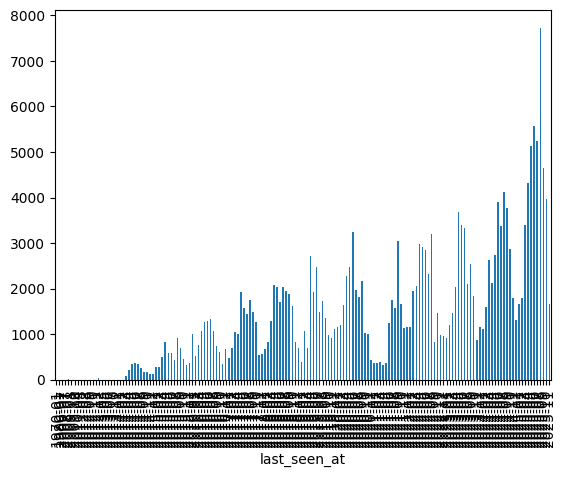

In [12]:
mapillary_trafficsigns_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


#### Zeitfilter 

In [ ]:
##  is newer than 2025-01-01  

# september 2025: 36488
# oktober   2025: 41263
# november  2025: 45075


mapillary_trafficsigns_cw=mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["last_seen_at"] > "2025-01-01"]
# mapillary_trafficsigns_237_recent
len(mapillary_trafficsigns_cw)

45075

In [14]:
mapillary_trafficsigns_cw

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
4217047,POINT (7.55566 47.81125),2021-07-17,501219351158581,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8535,5708
4217644,POINT (7.57416 47.83241),2025-08-17,3372394492916222,2025-08-17,regulatory--shared-path-pedestrians-and-bicycl...,8536,5706
4217646,POINT (7.57477 47.83541),2025-08-17,1420894112543504,2025-08-17,regulatory--shared-path-pedestrians-and-bicycl...,8536,5706
4217655,POINT (7.57627 47.84041),2025-08-17,1391720275857392,2025-08-17,regulatory--shared-path-pedestrians-and-bicycl...,8536,5706
4217701,POINT (7.57423 47.83254),2025-08-17,3372394496249555,2025-08-17,regulatory--shared-path-pedestrians-and-bicycl...,8536,5706
...,...,...,...,...,...,...,...
10575679,POINT (8.90864 53.05984),2025-05-16,1025090599601009,2025-05-16,regulatory--bicycles-only--g1,8597,5332
10576062,POINT (8.96325 53.05715),2025-08-16,3058286197696241,2025-08-16,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
10576066,POINT (8.96359 53.05766),2025-08-16,3058286184362909,2025-08-16,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
10576104,POINT (8.9643 53.05719),2025-08-16,1462451184804014,2025-08-16,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332


<Axes: xlabel='last_seen_at'>

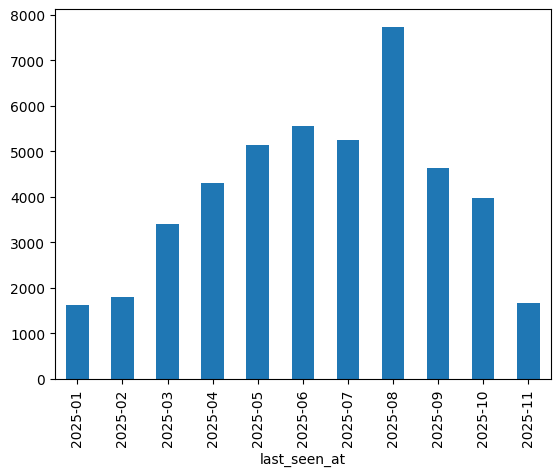

In [15]:
mapillary_trafficsigns_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


In [16]:
##  at least 12 months between first and last seen (to avoid temporary signs)
## might need to adjust this


zeitspanne = 9

def months_between(date1, date2):
    d1 = datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.strptime(date2, "%Y-%m-%d")
    return abs((d2.year - d1.year) * 12 + d2.month - d1.month)

mapillary_trafficsigns_cw_temp = mapillary_trafficsigns_cw[
    mapillary_trafficsigns_cw.apply(lambda row: months_between(row['first_seen_at'], row['last_seen_at']) >= zeitspanne, axis=1)
]
len(mapillary_trafficsigns_cw_temp)

17765

<Axes: xlabel='last_seen_at'>

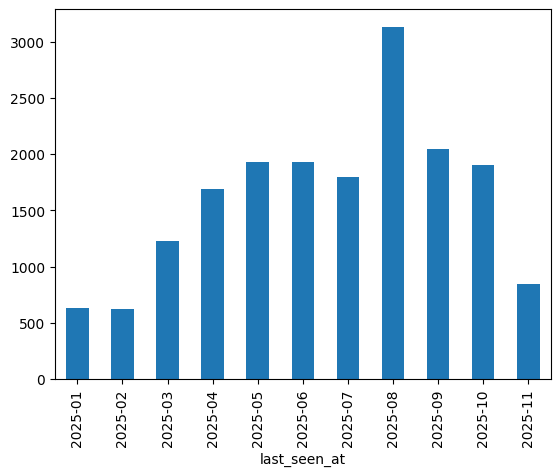

In [17]:
mapillary_trafficsigns_cw_temp.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")



<Axes: >

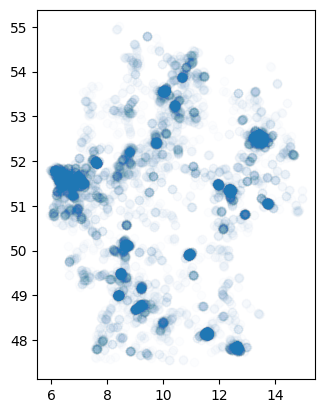

In [18]:
mapillary_trafficsigns_cw_temp.plot(alpha=0.01)

#### Räumliche Prüfung 

In [19]:
## now create a buffer around the traffic signs to check if there is a cycleway nearby
df_buffered_30 = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()
df_buffered_25 = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()

#df_buffered["geometry"] = df_buffered.geometry.buffer(50)
#df_buffered["geometry"] = df_buffered.geometry.buffer(40)
df_buffered_30["geometry"] = df_buffered_30.geometry.buffer(30)
df_buffered_25["geometry"] = df_buffered_25.geometry.buffer(25)


df_buffered_30 = df_buffered_30.to_crs(mapillary_trafficsigns_cw_temp.crs)
df_buffered_25 = df_buffered_25.to_crs(mapillary_trafficsigns_cw_temp.crs)


In [20]:
# helper 
def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [21]:
# For cycleways
df_buffered_30 = mark_intersections(df_buffered_30, filtered_cycleways, column_name="has_cw_intersection")
df_buffered_25 = mark_intersections(df_buffered_25, filtered_cycleways, column_name="has_cw_intersection")



# For motorways (just 30m for both)
df_buffered_30 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")
#df_buffered_20 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")



In [22]:
df_buffered_30["buffer_size"] = 30
df_buffered_25["buffer_size"] = 25

In [23]:
#df_buffered.id.unique()

In [24]:
# An wie vielen Schilder ist ein Radweg in der Nähe?
df_buffered_30.has_cw_intersection.value_counts()

has_cw_intersection
True     17596
False      169
Name: count, dtype: int64

In [25]:
df_buffered_25.has_cw_intersection.value_counts()

has_cw_intersection
True     17573
False      192
Name: count, dtype: int64

In [26]:
# An wie vielen Schilder ist eine Autobahn in der Nähe?
df_buffered_30.has_mw_intersection.value_counts()

has_mw_intersection
False    17628
True       137
Name: count, dtype: int64

In [27]:
df_buffered_30.has_mw_intersection

4217047     False
4217908     False
4218080     False
4218338     False
4218701     False
            ...  
10574096    False
10575476    False
10575487    False
10575556    False
10575570    False
Name: has_mw_intersection, Length: 17765, dtype: bool

In [28]:
df_buffered_25_false=df_buffered_25[(df_buffered_25.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
len(df_buffered_25_false)

118

In [29]:
df_buffered_30_false=df_buffered_30[(df_buffered_30.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
len(df_buffered_30_false)

95

In [30]:
df_buffered_25_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size
4230883,"POLYGON ((7.69661 47.96805, 7.69661 47.96803, ...",2015-05-29,223538512869319,2025-11-14,regulatory--bicycles-only--g1,8542,5697,False,25
4336020,"POLYGON ((8.45188 49.53249, 8.45188 49.53247, ...",2019-12-17,519227902580817,2025-08-30,regulatory--bicycles-only--g1,8576,5589,False,25
4751910,"POLYGON ((9.20918 49.1471, 9.20918 49.14707, 9...",2024-12-24,976931787662150,2025-09-11,regulatory--shared-path-pedestrians-and-bicycl...,8611,5616,False,25
4803341,"POLYGON ((9.26327 48.71377, 9.26327 48.71374, ...",2020-01-22,544036786609561,2025-05-15,regulatory--shared-path-pedestrians-and-bicycl...,8613,5646,False,25
4833418,"POLYGON ((9.33031 48.80523, 9.33031 48.80521, ...",2023-03-02,3402062016712875,2025-04-08,regulatory--shared-path-pedestrians-and-bicycl...,8616,5640,False,25
...,...,...,...,...,...,...,...,...,...
10329719,"POLYGON ((10.48236 53.99804, 10.48236 53.99802...",2024-07-22,837943328275932,2025-10-13,regulatory--shared-path-pedestrians-and-bicycl...,8669,5260,False,25
10355909,"POLYGON ((10.70606 53.9857, 10.70606 53.98568,...",2024-12-24,2360838470943192,2025-11-05,regulatory--shared-path-pedestrians-and-bicycl...,8679,5261,False,25
10370499,"POLYGON ((10.81652 54.10011, 10.81652 54.10008...",2024-03-14,938186811029926,2025-11-12,regulatory--shared-path-pedestrians-and-bicycl...,8684,5252,False,25
10382594,"POLYGON ((10.99454 54.18352, 10.99454 54.18349...",2021-10-01,420901199440466,2025-10-31,regulatory--shared-path-pedestrians-and-bicycl...,8692,5246,False,25


In [31]:
df_buffered_both_false= pd.concat([df_buffered_30_false, df_buffered_25_false]).sort_values("buffer_size").drop_duplicates(subset=['id'],keep="last")
df_buffered_both_false["buffer_size"].value_counts()

buffer_size
30    95
25    23
Name: count, dtype: int64

priority bei MapRoulette:

| Wert | Bedeutung         |
| ---- | ----------------- |
| 0    | High              |
| 1    | Medium (Standard) |
| 2    | Low               |


In [32]:
df_buffered_both_false["prio"] = df_buffered_both_false["buffer_size"].map({25: 1, 30: 0}).astype("Int64")

In [33]:
df_buffered_both_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio
4964596,"POLYGON ((9.89394 48.91584, 9.89394 48.91582, ...",2024-11-25,1295642021488461,2025-09-13,regulatory--shared-path-pedestrians-and-bicycl...,8642,5632,False,NaN,25,1
5100690,"POLYGON ((6.22062 51.72029, 6.22062 51.72027, ...",2024-06-09,2404100213109196,2025-08-24,regulatory--shared-path-pedestrians-and-bicycl...,8475,5432,False,NaN,25,1
5117423,"POLYGON ((6.2801 51.56703, 6.2801 51.56701, 6....",2024-11-24,1556861441864797,2025-10-04,regulatory--shared-path-pedestrians-and-bicycl...,8477,5443,False,NaN,25,1
5268787,"POLYGON ((6.62626 51.65903, 6.62626 51.65901, ...",2024-06-15,475166625009168,2025-05-31,regulatory--dual-path-bicycles-and-pedestrians...,8493,5436,False,NaN,25,1
5312389,"POLYGON ((6.68527 51.25473, 6.68527 51.25471, ...",2024-08-22,1045429763613453,2025-08-07,regulatory--dual-path-pedestrians-and-bicycles...,8496,5466,False,NaN,25,1
...,...,...,...,...,...,...,...,...,...,...,...
4899466,"POLYGON ((9.54721 48.52289, 9.54721 48.52287, ...",2024-10-11,1340089623883360,2025-10-02,regulatory--shared-path-pedestrians-and-bicycl...,8626,5659,False,False,30,0
5023028,"POLYGON ((5.95925 50.80572, 5.95925 50.80569, ...",2020-10-16,521837675499608,2025-05-09,regulatory--bicycles-only--g1,8463,5499,False,False,30,0
5022805,"POLYGON ((5.95921 50.80576, 5.95921 50.80573, ...",2014-11-19,918053748737717,2025-05-09,regulatory--bicycles-only--g1,8463,5499,False,False,30,0
5004330,"POLYGON ((10.08555 48.03986, 10.08555 48.03984...",2017-06-10,1794218264086039,2025-08-04,regulatory--shared-path-pedestrians-and-bicycl...,8650,5692,False,False,30,0


In [34]:
# interactive map
# df_buffered_false.explore(
#     color="red",
#     tiles="CartoDB positron",
#     popup=True,
#     tooltip=["value", "first_seen_at", "last_seen_at"]
# )

In [38]:
import json
import requests

#### clean up from existing maproulette challenge

In [47]:
### import the the flagged (not created, fixed) tasks from the challenge. 

# challenge_gdf = gpd.read_file("challenge_52916_data_f_mr.geojson")
#challenge_gdf.head()

with open("../utils/config_mapillary_privat.json", "r") as f:
    config = json.load(f)
API_KEY = config["API_KEY_MAPROULETTE"]

CHALLENGE_ID = 52916
BASE_URL = "https://maproulette.org/api/v2"

headers = {"apiKey": API_KEY}

# Single request to get all tasks as GeoJSON
r = requests.get(
    f"{BASE_URL}/challenge/view/{CHALLENGE_ID}",
    headers=headers
)
r.raise_for_status()
geojson_data = r.json()

# Convert directly to GeoDataFrame
challenge_gdf = gpd.GeoDataFrame.from_features(geojson_data, crs='EPSG:4326')

challenge_gdf=challenge_gdf[~challenge_gdf.mr_taskStatus.isin(["Fixed", "Created", "Skipped"])]

df_buffered_both_false = df_buffered_both_false.to_crs(4326)

# Find intersections
intersections = gpd.sjoin(df_buffered_both_false, challenge_gdf, how="left", predicate="intersects")

# Keep only rows that do NOT intersect (i.e., no match in challenge_gdf)
df_buffered_both_false_no_challenge = df_buffered_both_false.loc[intersections.index[intersections["index_right"].isna()]] 

len(df_buffered_both_false_no_challenge)


64

### retrieve the image ID for the map features

In [48]:
#df_process_img= df_buffered_false.copy()
df_process_img= df_buffered_both_false_no_challenge.copy()

In [49]:
import sys
import os
import json
import logging
from contextlib import contextmanager
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------------------------------------------------------------


# -- suppress stdout context manager --
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# -- Load config & set Mapillary token --
with open("config_mapillary_privat.json", "r") as f:
    config = json.load(f)

access_token = config["ACCESS_TOKEN"]
mly.interface.set_access_token(access_token)

# -- Logging cleanup --
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

# -- Your image fetching function --
def get_image_id(map_feature_id):
    try:
        feature_str = mly.interface.feature_from_key(key=str(map_feature_id))
        feature = json.loads(feature_str)
        images = feature["features"]["properties"]["images"]["data"]
        return images[-1]["id"] if images else None
    except Exception as e:
        return None  # Or log the error if needed

# -- Parallelized version using ThreadPoolExecutor --
def parallel_get_image_ids(ids, max_workers=8):
    results = [None] * len(ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_image_id, id_): idx for idx, id_ in enumerate(ids)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching image IDs"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None  # Or log
    return results

# -- Apply to your dataframe --
with suppress_stdout():
    df_process_img["image_id"] = parallel_get_image_ids(df_process_img["id"].tolist(), max_workers=5)  # Adjust max_workers as needed, 5 is fastest for me


Fetching image IDs: 100%|██████████| 64/64 [00:14<00:00,  4.51it/s]


In [50]:
## https://www.mapillary.com/app/?pKey=1029316554880692

df_process_img.head()



,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id
4964596,"POLYGON ((9.89394 48.91584, 9.89394 48.91582, ...",2024-11-25,1295642021488461,2025-09-13,regulatory--shared-path-pedestrians-and-bicycl...,8642,5632,False,NaN,25,1,605747075420421
5117423,"POLYGON ((6.2801 51.56703, 6.2801 51.56701, 6....",2024-11-24,1556861441864797,2025-10-04,regulatory--shared-path-pedestrians-and-bicycl...,8477,5443,False,NaN,25,1,1354210899283059
5268787,"POLYGON ((6.62626 51.65903, 6.62626 51.65901, ...",2024-06-15,475166625009168,2025-05-31,regulatory--dual-path-bicycles-and-pedestrians...,8493,5436,False,NaN,25,1,1505711967030691
5601958,"POLYGON ((7.03101 51.53323, 7.03101 51.53321, ...",2021-09-20,170297258607479,2025-04-15,regulatory--bicycles-only--g1,8511,5446,False,NaN,25,1,4772613432800885
10544325,"POLYGON ((12.09896 50.90062, 12.09896 50.9006,...",2023-10-23,200961383029793,2025-10-02,regulatory--dual-path-bicycles-and-pedestrians...,8742,5492,False,NaN,25,1,260350826534446


In [51]:
# to points, to 4326

centroids = df_process_img.copy()
centroids=centroids.to_crs(25832)
centroids["geometry"] = centroids.geometry.centroid
centroids=centroids.to_crs(4326)

centroids.sort_values("last_seen_at")


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id
9357941,POINT (13.49265 52.63668),2021-09-26,1061132341374293,2025-03-09,regulatory--bicycles-only--g1,8806,5364,False,NaN,25,1,878574059435800
8874979,POINT (12.46538 47.77464),2024-05-01,822500396409723,2025-03-22,regulatory--shared-path-pedestrians-and-bicycl...,8759,5710,False,False,30,0,412055998469019
4849978,POINT (9.36096 48.87016),2024-04-08,1129066038517150,2025-03-29,regulatory--shared-path-pedestrians-and-bicycl...,8618,5635,False,False,30,0,7365155340247199
5601958,POINT (7.03065 51.53321),2021-09-20,170297258607479,2025-04-15,regulatory--bicycles-only--g1,8511,5446,False,NaN,25,1,4772613432800885
7424161,POINT (8.66071 50.23648),2024-07-08,1577542942830254,2025-04-16,regulatory--shared-path-pedestrians-and-bicycl...,8586,5539,False,False,30,0,1538058936880079
...,...,...,...,...,...,...,...,...,...,...,...,...
10355909,POINT (10.70568 53.98569),2024-12-24,2360838470943192,2025-11-05,regulatory--shared-path-pedestrians-and-bicycl...,8679,5261,False,False,30,0,950732979801561
7931524,POINT (12.19575 51.5539),2017-03-06,198961558581320,2025-11-08,regulatory--shared-path-pedestrians-and-bicycl...,8747,5444,False,False,30,0,456945498747167
5670829,POINT (7.0914 51.57273),2018-04-07,1055358451658816,2025-11-09,regulatory--shared-path-pedestrians-and-bicycl...,8514,5443,False,False,30,0,518263102931731
10370499,POINT (10.81614 54.10009),2024-03-14,938186811029926,2025-11-12,regulatory--shared-path-pedestrians-and-bicycl...,8684,5252,False,False,30,0,764754185376778


In [52]:
# Mapping dictionary
value_to_vz = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': 241,
    'regulatory--dual-path-bicycles-and-pedestrians--g1': 241,
    'regulatory--bicycles-only--g1': 237,
    'regulatory--shared-path-pedestrians-and-bicycles--g1': 240
}

# Add new column based on mapping
centroids["VZ"] = centroids["value"].map(value_to_vz)

In [53]:
#centroids

In [54]:
centroids

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id,VZ
4964596,POINT (9.8936 48.91582),2024-11-25,1295642021488461,2025-09-13,regulatory--shared-path-pedestrians-and-bicycl...,8642,5632,False,NaN,25,1,605747075420421,240
5117423,POINT (6.27974 51.567),2024-11-24,1556861441864797,2025-10-04,regulatory--shared-path-pedestrians-and-bicycl...,8477,5443,False,NaN,25,1,1354210899283059,240
5268787,POINT (6.6259 51.659),2024-06-15,475166625009168,2025-05-31,regulatory--dual-path-bicycles-and-pedestrians...,8493,5436,False,NaN,25,1,1505711967030691,241
5601958,POINT (7.03065 51.53321),2021-09-20,170297258607479,2025-04-15,regulatory--bicycles-only--g1,8511,5446,False,NaN,25,1,4772613432800885,237
10544325,POINT (12.09861 50.90061),2023-10-23,200961383029793,2025-10-02,regulatory--dual-path-bicycles-and-pedestrians...,8742,5492,False,NaN,25,1,260350826534446,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5102747,POINT (6.24006 51.1359),2020-08-08,1018980228632451,2025-08-15,regulatory--shared-path-pedestrians-and-bicycl...,8475,5475,False,False,30,0,244559397457229,240
5029866,POINT (6.04388 50.92168),2024-10-18,561251686372564,2025-08-13,regulatory--bicycles-only--g1,8467,5490,False,False,30,0,1316678576406715,237
4899466,POINT (9.5468 48.52288),2024-10-11,1340089623883360,2025-10-02,regulatory--shared-path-pedestrians-and-bicycl...,8626,5659,False,False,30,0,1058924752090298,240
5004330,POINT (10.08515 48.03984),2017-06-10,1794218264086039,2025-08-04,regulatory--shared-path-pedestrians-and-bicycl...,8650,5692,False,False,30,0,801389947476912,240


In [55]:
centroids["prio_text"] = centroids["prio"].map({
    0: "🟩 Task mit hoher Wahrscheinlichkeit valide",
    1: "🟨 Task mit mittlerer Wahrscheinlichkeit valide",
    2: "🟥 Task mit eher geringer Wahrscheinlichkeit valide"
})

centroids[["prio", "prio_text"]].head()

,prio,prio_text
4964596,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
5117423,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
5268787,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
5601958,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
10544325,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide


In [56]:
#centroids.plot()

In [57]:
import uuid

def to_maproulette_geojson_with_links(gdf, id_field="id", name_field="value", image_field="image_id"):
    features = []

    for _, row in gdf.iterrows():
        geom = row.geometry
        centroid = geom.centroid
        lat, lon = round(centroid.y, 6), round(centroid.x, 6)

        # Optional: Mapillary image
        image_url = None
        image_id = None
        if pd.notna(row.get(image_field)):
            image_id = str(int(row[image_field]))
            image_url = (
                f"https://www.mapillary.com/app/?pKey={image_id}"
                "&focus=photo"
                "&trafficSign[]=regulatory--bicycles-only--g1"
                "&trafficSign[]=regulatory--shared-path-pedestrians-and-bicycles--g1"
                "&trafficSign[]=regulatory--dual-path-bicycles-and-pedestrians--g1"
                "&trafficSign[]=regulatory--dual-path-pedestrians-and-bicycles--g1"
            )

        # TILDA link
        tilda_url = f"https://tilda-geo.de/regionen/radinfra?map=17.4/{lat}/{lon}&config=pdqyyt.7h3d.16g9vk&v=2&data=mapillary-cycleway-traffic-signs"

#         # Build instruction
        instruction = f"""  
### 🚧 Aufgabe: Verkehrszeichen **DE:{row["VZ"]}** überprüfen und Radinfra hinzufügen
Bitte schaue dir den Bereich rund um dieses erkannte Verkehrszeichen an. Vermutlich fehlt hier eine Radinfrastruktur, die du hinzufügen kannst. Die nächste OSM-Radinfra ist mind. **{row["buffer_size"]} Meter** entfernt.

---

### 🖼️ Bild & Karte

- 📷 [**Mapillary-Bild anzeigen**]({image_url})  
(Hinweis: Das zuerst angezeigte Bild ist wahrscheinlich nicht das neueste – die neueste Aufnahme hier ist von **{row["last_seen_at"]})**

- 🗺️ [**In radinfra.de bzw TILDA ansehen**]({tilda_url})  
(Hinweis: Ist hilfreich um den aktuellen Stand der Radinfrastruktur vor Ort zu prüfen.)

---

### 📚 Nützliche Links

- 🛑 [**Traffic Sign Tool** – DE:{row["VZ"]}](https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:{row["VZ"]})  
- 🚴 [**OSM-Wiki: Radverkehrsanlagen kartieren**](https://wiki.openstreetmap.org/wiki/DE:Bicycle/Radverkehrsanlagen_kartieren)

---

Viel Erfolg beim Prüfen und Mappen! 🗺️
        """

        # Build properties
        props = {
            #"identifier": str(row[id_field]),
            "image_id": image_id,
            "Verkehrzeichen": str(row["VZ"]),
            "instruction": instruction,   #.strip(),
            "priority":  row["prio"],
            "name": row["prio_text"]
        }

        # Build feature
        feature = {
            "type": "Feature",
            "geometry": row["geometry"].__geo_interface__,
            "properties": props,
            # Set the top-level ID here
            "id":  str(row[id_field]), # detection Id
           # "priority":  row["prio"] 
        }

        # # Add Mapillary attachment if available
        # if image_id:
        #     feature["attachments"] = [
        #         {
        #             "id": str(uuid.uuid4()),
        #             "kind": "referencePhoto",
        #             "type": "mapillary",
        #             "format": "image",
        #             "data": image_id
        #         }
        #     ]

        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features
    }


In [58]:
# Convert your df_buffered_false (or any GeoDataFrame) to GeoJSON
maproulette_geojson = to_maproulette_geojson_with_links(centroids)

# Save to file
with open("maproulette_tasks_missing-cw_instruction_vz_name_new.geojson", "w") as f:
    json.dump(maproulette_geojson, f, indent=2)


In [ ]:
### Maproulette stuff....

In [ ]:
## Add missing cycleways based on mapillary signs (Germany)


## 🚲 Fehlende Radwege anhand von Mapillary-Verkehrszeichen ergänzen (Deutschland)

Diese Challenge basiert auf automatisch erkannten, radverkehrsbezogenen Verkehrszeichen aus Mapillary-Bildern in Deutschland.

### 📌 Kriterien für jede Aufgabe

Nur Aufgaben, die **alle** folgenden Bedingungen erfüllen, wurden berücksichtigt:

- Das Verkehrszeichen wurde **in Mapillary erkannt**.
- Es handelt sich um ein **radverkehrsbezogenes Zeichen**  
  *(z. B. gemeinsamer Geh- und Radweg, reiner Radweg, getrennter Geh-/Radweg)*.
- Das Zeichen wurde **mindestens 12 Monate lang regelmäßig gesehen**.
- Die neuste Aufnahme stammt **aus dem Jahr 2025**.
- Es existiert **kein OSM-"Radweg" innerhalb von 30 m** des Standortes.

---

### 🔍 Was du tun solltest

1. Öffne den Ort in **Mapillary** und **radinfra.de** sowie einem Editor.
2. Prüfe, ob an der Stelle eine **Radinfrastruktur fehlt**.
3. Falls ja, ergänze die passenden OSM-Tags:  
   z. B. `highway=cycleway`, `cycleway=*`, `bicycle=designated`, etc.
4. Wenn bereits alles korrekt gemappt ist, kannst du die Aufgabe einfach **als erledigt markieren**.

---

🗺️ Vielen Dank für deine Hilfe beim Ausbau der Radinfrastruktur in OSM!

In [ ]:
'''
{{instruction}}
                                                                                             .
'''